# Diagnosing COVID-19 using Chest X-rays with fast.ai

## Downloading the dataset

For more information about the dataset please visit https://covidresearch.ai/datasets/dataset?id=2

In [ ]:
! wget https://covidresearchpubdatasets.blob.core.windows.net/covid19xrayimages/data.tar.xz

In [ ]:
! unxz data.tar.xz

In [ ]:
! tar -xf data.tar

## Processing the Data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
temp = ! pwd

In [5]:
path = Path(temp)/'data'

In [6]:
classes = (path/'train').ls(); classes

[PosixPath('/data/home/jdavey/notebooks/fastai/data/corona/data/train/pneumonia'),
 PosixPath('/data/home/jdavey/notebooks/fastai/data/corona/data/train/normal'),
 PosixPath('/data/home/jdavey/notebooks/fastai/data/corona/data/train/COVID-19')]

Setting the batch side - this may have to be decreasing if you're not using a gpu

In [7]:
bs = 128

In [8]:
np.random.seed(3)
src = ImageList.from_folder(path).split_by_rand_pct(0.2).label_from_folder()

In [9]:
data = src.transform(tfms=get_transforms(), size=224, resize_method=ResizeMethod.SQUISH).databunch(bs=bs, num_workers=4).normalize()

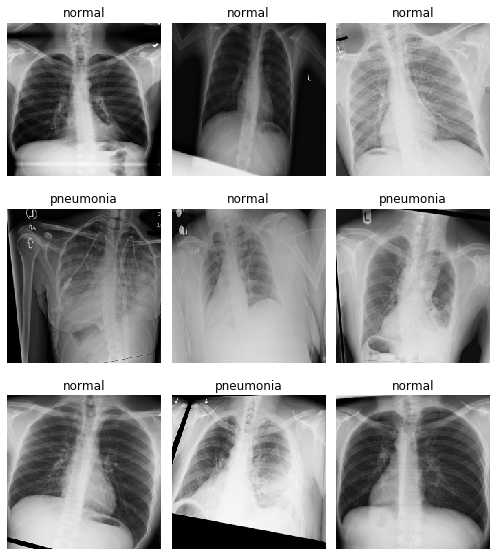

In [11]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID-19', 'normal', 'pneumonia'], 3, 12000, 3000)

In [11]:
arch = models.resnet50

Metrics do not change the model, just adjust what is printed out

In [12]:
learn = cnn_learner(data, arch, metrics=error_rate)

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


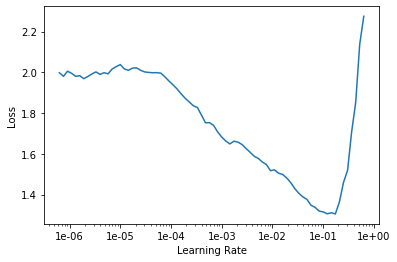

In [17]:
learn.recorder.plot()

Choose the learning rate to be the point of greatest gradient which is around 10x below the minimum point

In [14]:
lr = 0.002

In [19]:
learn.fit_one_cycle(5, slice(2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.651651,0.452911,0.116333,03:49
1,0.334713,0.277092,0.096667,03:34
2,0.264989,0.242155,0.087333,03:35
3,0.239992,0.232724,0.082667,03:35
4,0.220912,0.225942,0.082333,03:35


In [20]:
learn.save('stage-1-rn50')

Note: If the model crashes you can use learn.load(name) to revert back to the last point where you saved the model. e.g. learn.load('stage-1-rn50') to revert back to the weight in the line above

In [21]:
learn.unfreeze()

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


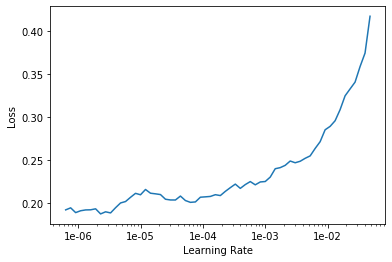

In [23]:
learn.recorder.plot()

Choose the first part of the slice to be 10x back from where the curve flattens

In [24]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.212037,0.218132,0.076333,04:40
1,0.202998,0.202464,0.068667,04:42
2,0.176155,0.190928,0.067333,04:42
3,0.158515,0.185168,0.066667,04:42
4,0.153050,0.187236,0.066667,04:42


In [25]:
learn.save('stage-2-rn50')

Reducing the batch side, this is as the image size is now being increased from 224 to 448 so will take up more memory

In [23]:
bs = 16

Resizing data

In [14]:
data = src.transform(tfms=get_transforms(), size=448, resize_method=ResizeMethod.SQUISH).databunch(bs=bs, num_workers=4).normalize()

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [17]:
learn.freeze()

This will free up unused gpu memory

In [17]:
gc.collect()


15

In [32]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


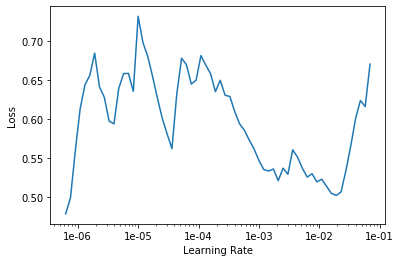

In [27]:
learn.recorder.plot()

In [16]:
lr=0.0004

In [34]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.222110,0.201404,0.068667,13:10
1,0.206786,0.190490,0.066333,13:05
2,0.190574,0.201486,0.069667,13:06
3,0.193247,0.179169,0.062333,13:06
4,0.189294,0.228964,0.079000,13:06


In [35]:
learn.save('stage-1-448-rn50')

In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.232740,0.265958,0.096000,17:56
1,0.175234,0.164825,0.057333,17:37
2,0.169016,0.151603,0.050000,17:38
3,0.133142,0.144247,0.047667,17:37
4,0.110215,0.147949,0.049333,17:37


In [21]:
learn.save('stage-2-448-rn50')

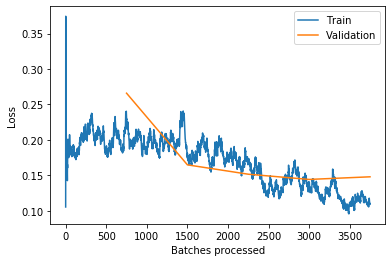

In [22]:
learn.recorder.plot_losses()

In [23]:
learn.export()

## Testing results

In [66]:
src = ImageList.from_folder(path/'test').split_none().label_from_folder()

In [67]:
data = src.transform(tfms=get_transforms(), size=448, resize_method=ResizeMethod.SQUISH).databunch(bs=bs, num_workers=4).normalize()

data_test.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [68]:
bs = 64

In [69]:
arch = models.resnet50
learn = cnn_learner(data_test, arch, metrics=error_rate)

In [ ]:
learn.load(path/'models'/'stage-2-448-rn50')

In [73]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

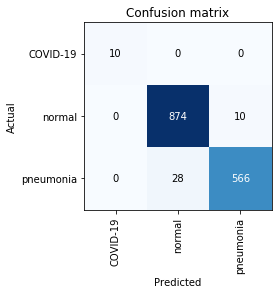

In [75]:
interp.plot_confusion_matrix()